<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_data_generation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Data Generation (v1)
This is the first notebook to really seriously look into generating realistic training data for the SLAM model.

This notebook follows on from `Experiment-SLAM-2.ipynb`.

**Focus for this notebook:**
* Generating more realistic LDS data with physically realistic noise.
* Getting agent and map locations more physically realistic.

**Problems identified in Experiment-SLAM-2:**

A number of problems with the data generation were identified there:
* Input maps are too complete and too perfect. They're exactly the same as the ground-truth maps, so there's nothing for the NN to do, and no incentive to use the LDS data to improve the map.
* The NN should always prefer the LDS data over its the input map, as the input map represents only a guess, while LDS is true state. I don't think I've got this balanced quite right in the training data yet.

**Suggestions from Experiment-SLAM-2:**

Some initial ideas for improving the training data were:
* Simulate an agent actually moving around an environment and building up the map from parts, instead of the current extremes: being given either a fully-known map or no-map in between.
  * Imagine taking a path along the map.
  * At each location collect what it can see within the LDS range - this collects a circle of data.
  * Then add some noise the LDS data before turning it into the input map.
  * Later on optionally add motion-skew (where the agent continuously slowly slides slightly to one side so that the SLAM map ends up over a curve and the NN will have to correct that).
  * API note: add collection of options for turning different kinds of errors on/off.
* Play around with occlusions more. Instead of being given a full map for the current location it should be given only a partial map, forcing it to do a partial-match on the map and the LDS data. eg:
  * Randomly drop half of the input map, centred on the map centre, according to a dividing line that goes through the centre at some random angle.
  * Use ~1/3rd sized circles of LDS range and randomly splat them around the map filling in only the parts that are splatted. Do this to build up the input map that is then snapshotted. Take a random number of splats, to simulate different levels of known map. Could be easy to implement by first building up mask from the splats and then applying that against the full map.

In [143]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout 66c41c3
#!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
import slam_data_test
import map_from_lds_train_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)
reload(slam_data_test)

# run tests
slam_data_test.run_test_suite()

HEAD is now at 37821eb Avoid large data sizes by using float32 for semantic_map representation
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 426 bytes | 142.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   37821eb..66c41c3  main       -> origin/main
Updating 37821eb..66c41c3
Fast-forward
 slam_data.py | 5 ++++-
 1 file changed, 4 insertions(+), 1 deletion(-)


In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00


## LDS sampling with noise

In [3]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")


RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


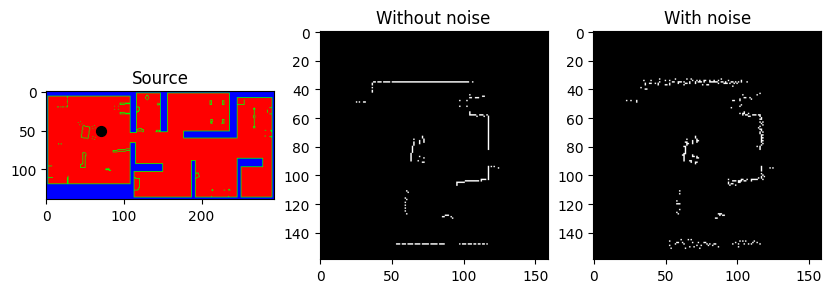

In [4]:
reload(lds)
loc = (70.0, 50.0)
ranges1 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0, noise_ranges=None)
lds_points1 = lds.lds_to_occupancy_map(ranges1, angle=0.0)

ranges2 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0)
lds_points2 = lds.lds_to_occupancy_map(ranges2, angle=0.0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('Source')
plt.imshow(floorplan)
plt.scatter(loc[0], loc[1], c='k', s=50)

plt.subplot(1,3,2)
plt.title("Without noise")
plt.imshow(lds_points1, cmap='gray')

plt.subplot(1,3,3)
plt.title("With noise")
plt.imshow(lds_points2, cmap='gray')

plt.show()



Generating 5 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [2]


100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


Generated 5 samples after 5 attempts
Dataset tests passed (5 entries verified)
map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.04488318 -0.0763452   0.29178823]


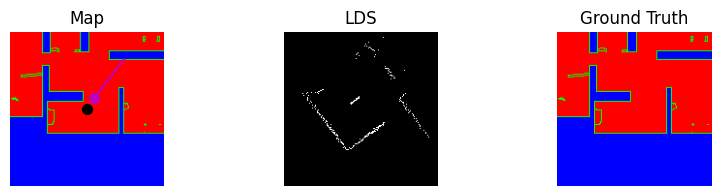

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3151994  -0.28233716  0.94763739]


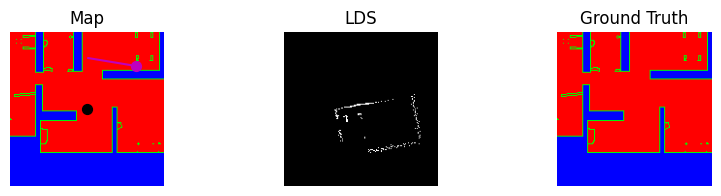

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.20125685 -0.43166362  0.00165638]


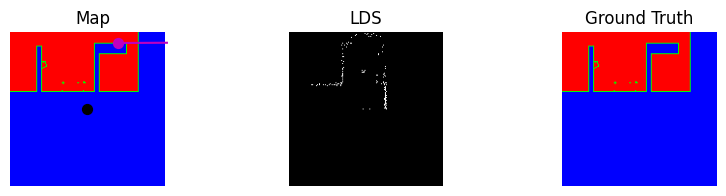

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.19429149 -0.47798202  0.46815136]


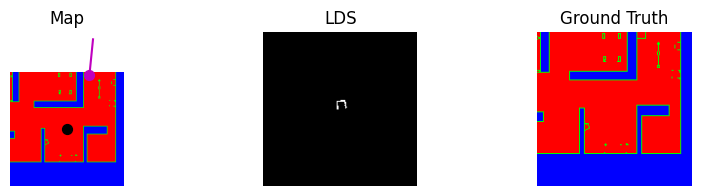

map_window:       (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.44498492 -0.17447237 -0.21883381]


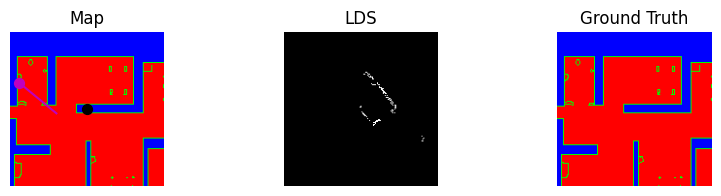

In [5]:
reload(lds)
reload(slam_data)
np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, 5, sample_types=(2))
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)

## Next Steps

Using model to generate input maps:
* Next step is to start using the model to generate the input map in the training data set.
* Probably split out the training into aeons.
During the first aeon it'll use ground-truth generated input maps.
At the end of each aeon it'll generate new input maps for the dataset and use them in the next aeon.

Improve code:
* The slam_data `generate_training_data_sample` function is a little bit of a mess now. The API I threw together in haste is counter to the way I'm now using it. So that nedes cleaning up.

## Using Model to Generate Map
First, we'll use the model to take a series of snapshots around the floorplan.We'll save them individually, so that we can later dynamically construct model-generated maps of different sections of the floorplan at will.
In other words, in a very crude but time-efficient way, we can simulate the agent taking different paths and having different versions of the map.

In [6]:
!ls

experimental-slam-model3-50epochs.keras  repo  sample_data


In [7]:
## Load an existing model
# (note: the 100epochs file is apparently corrupted)
model = tf.keras.models.load_model('experimental-slam-model3-50epochs.keras')

In [8]:
# conversion from pixel to physical coordinates:
# - a pixel's physical coordinate is at its centre, so the physical coords have range +/- 0.5 of that location
# - a pixel-shape of (2,2) has px coords in range 0..1, if we extend to include the border then we have -0.5..+1.5
def get_location_range(semantic_map, exclude_border=False, **kwargs):
  """
  Centralises the maths to accurately define the range of physical locations across a semantic map.
  Optionally skips the half-pixel width around the edges.
  Both returned low-high have a small margin removed so that it doesn't matter whether subsequent processing treats them as inclusive or exclusive.
  Args:
    semantic_map: entire floorplan or selection
    exclude_border: whether to omit the half-pixel width on the edges.
      Can be used as a very simplistic heuristic to skip the outermost edge that probably has no useful points anyway.
  Returns:
    (low, high) - where low/high are both (x,y) coordinates
  """
  pixel_size = kwargs.get('pixel_size', lds.__PIXEL_SIZE__)
  h, w = np.array(semantic_map.shape[0:2])
  if exclude_border:
    low_px = np.array((0, 0))
    high_px = np.array((w-1, h-1))
  else:
    low_px = np.array((-0.4999, -0.4999))
    high_px = np.array((w-0.5001, h-0.5001))

  return low_px * pixel_size, high_px * pixel_size

range_full = get_location_range(floorplan)
range_reduced = get_location_range(floorplan, exclude_border=True)
print(f"floorplan (px):     {floorplan.shape[1]} x {floorplan.shape[0]}")
print(f"floorplan (mm):     {floorplan.shape[1]*lds.__PIXEL_SIZE__} x {floorplan.shape[0]*lds.__PIXEL_SIZE__}")
print(f"range_full (mm):    {range_full[0]} - {range_full[1]} = {range_full[1] - range_full[0]}")
print(f"range_reduced (mm): {range_reduced[0]} - {range_reduced[1]} = {range_full[1] - range_full[0]}")

floorplan (px):     294 x 139
floorplan (mm):     13144.74 x 6214.6900000000005
range_full (mm):    [-22.350529 -22.350529] - [13122.380529  6192.330529] = [13144.731058  6214.681058]
range_reduced (mm): [0. 0.] - [13100.03  6169.98] = [13144.731058  6214.681058]


Generating 85 LDS maps...


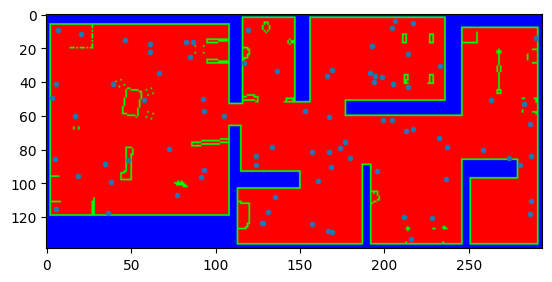

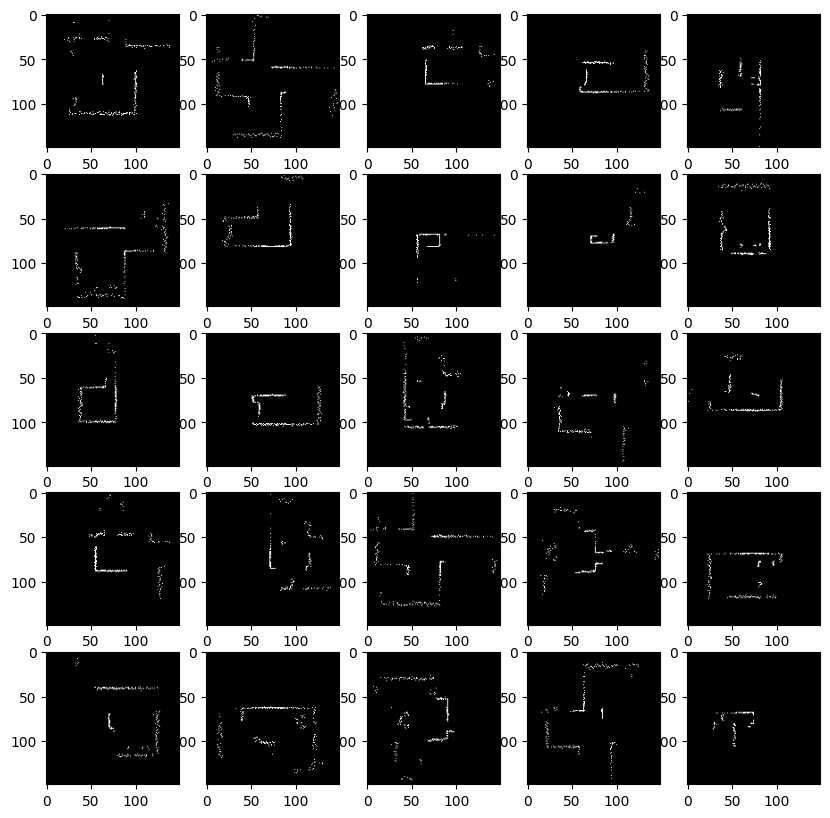

In [19]:
def show_samples(locations, orientations, maps):
  pixel_size = lds.__PIXEL_SIZE__
  plt.imshow(floorplan)
  plt.plot(locs[:,0] / pixel_size, locs[:,1] / pixel_size, '.')
  plt.show()

  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(maps[i], cmap='gray')
  plt.show()

np.random.seed(0)
locs, orientations, lds_maps = slam_data.take_samples_covering_map(floorplan, sampling_mode='random')
show_samples(locs, orientations, lds_maps)

Generating 85 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step


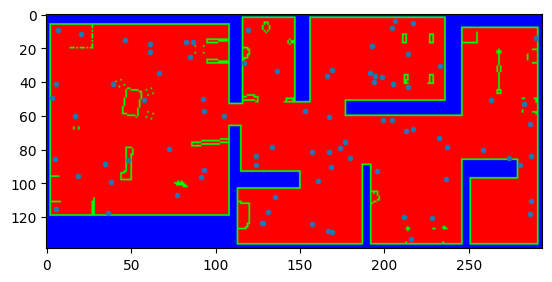

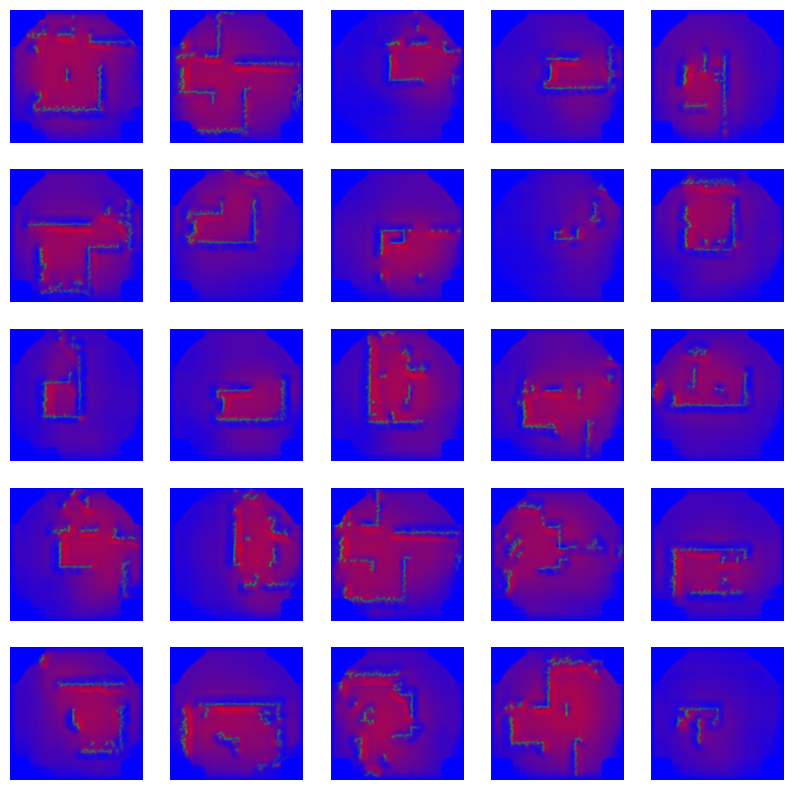

In [35]:
def show_semantic_samples(locations, orientations, semantic_maps):
  pixel_size = lds.__PIXEL_SIZE__
  plt.imshow(floorplan)
  plt.plot(locs[:,0] / pixel_size, locs[:,1] / pixel_size, '.')
  plt.show()

  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(semantic_maps[i])
    plt.axis('off')
  plt.show()

reload(slam_data)
np.random.seed(0)
locs, orientations, _, semantic_maps = slam_data.take_samples_covering_map(floorplan, model, sampling_mode='random')
show_semantic_samples(locs, orientations, semantic_maps)

## Combining semantic maps

In [142]:
np.zeros((3,5)).astype(np.float32).dtype

dtype('float32')

out: float64 x (139, 294, 3)
location_start: [0. 0.]


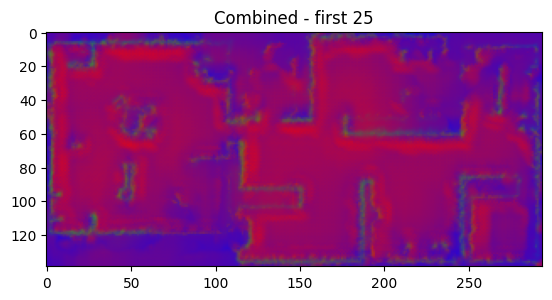

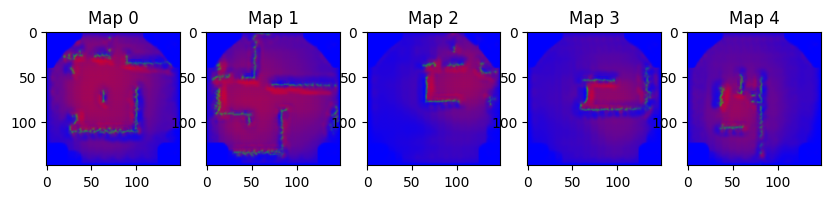

In [140]:
indices = range(25)
output_range_px = (0, 0, floorplan.shape[1], floorplan.shape[0])
out, location_start = slam_data.combine_semantic_maps(tf.gather(locs, indices), tf.gather(semantic_maps, indices), output_range_px=output_range_px)

print(f"out: {out.dtype} x {out.shape}")
print(f"location_start: {location_start}")

plt.title("Combined - first 25")
plt.imshow(out)
plt.show()

plt.figure(figsize=(10,3))
for i, indice in enumerate(indices[0:5]):
  plt.subplot(1,5,i+1)
  plt.title(f"Map {indice}")
  plt.imshow(semantic_maps[indice])
plt.show()


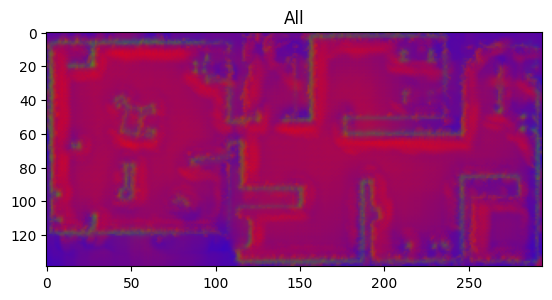

In [22]:
out = slam_data.combine_semantic_maps(locs, semantic_maps, output_range_px=output_range_px)
plt.title("All")
plt.imshow(out)
plt.show()

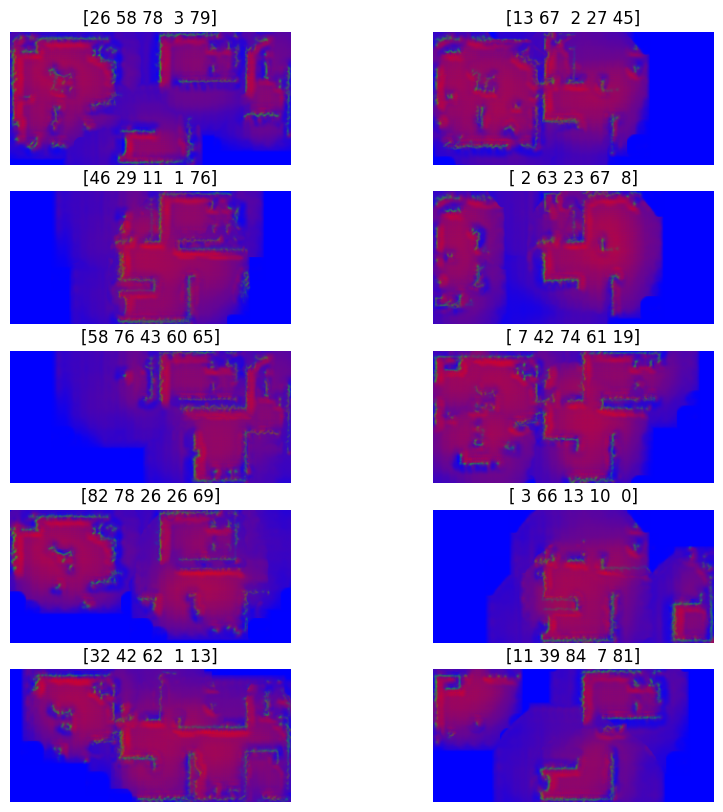

In [23]:
num = 5
output_range_px = (0, 0, floorplan.shape[1], floorplan.shape[0])
plt.figure(figsize=(10,10))
for i in range(num):
  for j in range(2):
    plt.subplot(5,2,i*2+j+1)
    indices = np.random.uniform(0, len(semantic_maps), size=(5,)).astype(int)
    out = slam_data.combine_semantic_maps(tf.gather(locs, indices), tf.gather(semantic_maps, indices), output_range_px=output_range_px)
    plt.title(indices)
    plt.imshow(out)
    plt.axis('off')
plt.show()

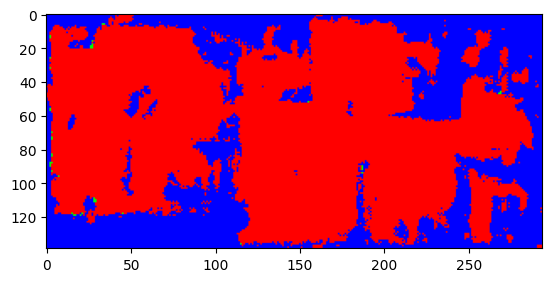

In [24]:
out = slam_data.combine_semantic_maps(locs[0:25], semantic_maps[0:25], output_range_px=output_range_px)
plt.imshow(tf.one_hot(np.argmax(out, axis=-1), depth=3))

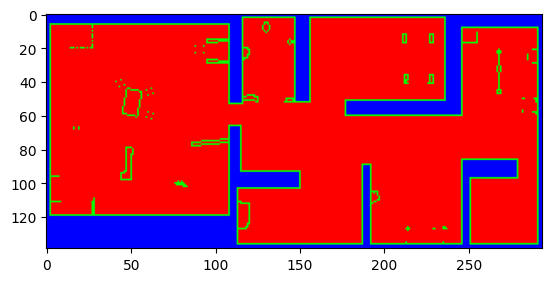

In [ ]:
plt.imshow(floorplan)

## Data generation with Model-generated Input Maps

In [ ]:
reload(slam_data)
np.random.seed(0)
predicted_sample_locs, _, _, predicted_sample_maps = slam_data.take_samples_covering_map(floorplan, model, sampling_mode='random')

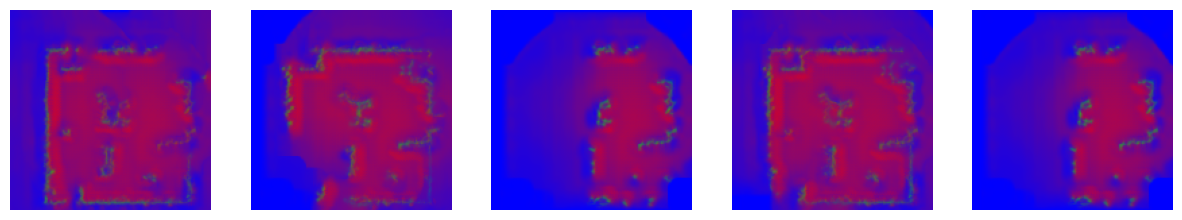

In [108]:
np.random.seed(0)
plt.figure(figsize=(15,3))
num = 5
for i in range(num):
  plt.subplot(1,num,i+1)
  centre = np.array([50,50]) * lds.__PIXEL_SIZE__
  combined = slam_data.pre_sampled_crop(centre, (149,149), predicted_sample_locs, predicted_sample_maps, sampling_mode='centre-first', max_samples=5)
  plt.imshow(combined)
  plt.axis('off')
plt.show()

Generating 10 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [0 1 2 3]
Input maps: using predicted input maps with weight 0.85


100%|██████████| 10/10 [00:00<00:00, 12.50it/s]


Generated 10 samples after 10 attempts
input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [1. 0. 0. 0.]


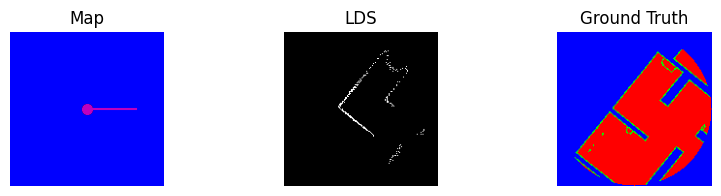

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.06650611 -0.13208251 -0.31531525]


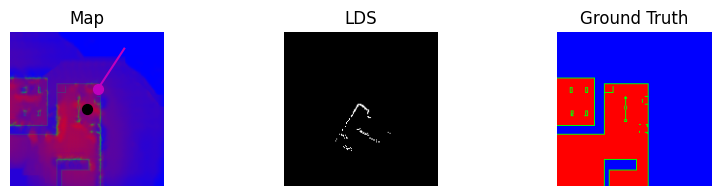

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.02039718  0.03010585  0.06659514]


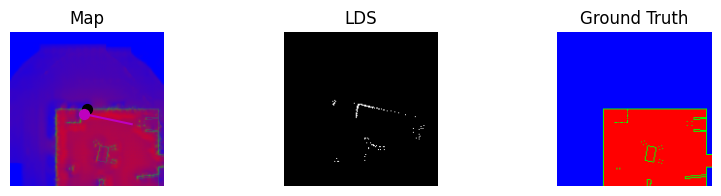

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [0. 0. 0. 0.]


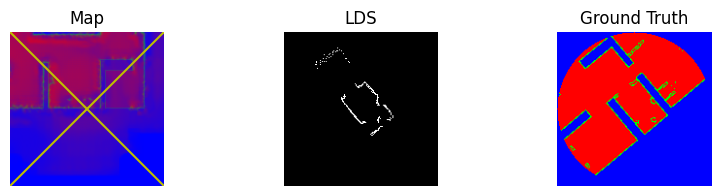

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [0. 0. 0. 0.]


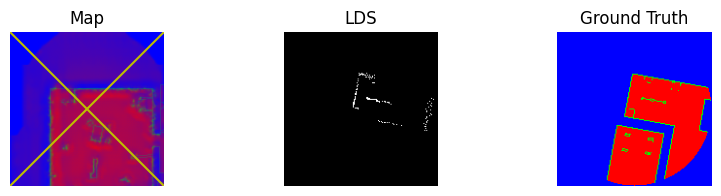

In [128]:
np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, num_samples=10, sample_types=[0, 1, 2,3], predicted_samples=(predicted_sample_locs, predicted_sample_maps))
slam_data.show_dataset(dataset)

## Generate and save this new training data

Generating 1000 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [0 1 2 3]
Input maps: using predicted input maps with weight 1.0
Generating 85 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 14s/step
Generating training data...


100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


Generated 1000 samples after 1000 attempts
Dataset generated in 267.04355565399965 sec
Dataset tests passed (1000 entries verified)
input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3613129  -0.14542208 -0.84998183]


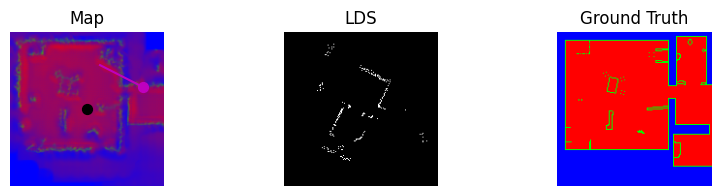

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [1. 0. 0. 0.]


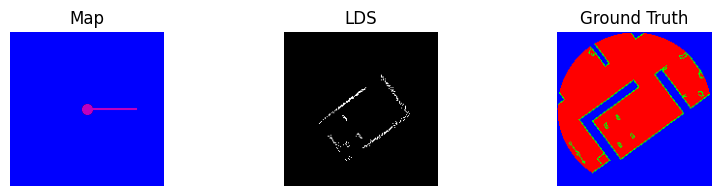

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.4288581  -0.16917454  0.88887873]


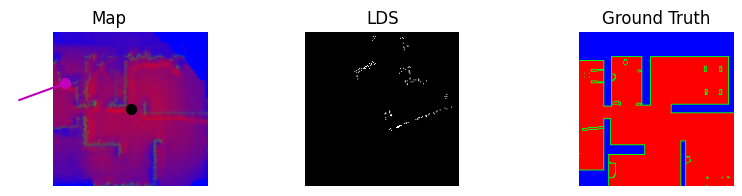

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.08887662 -0.4728966  -0.44646913]


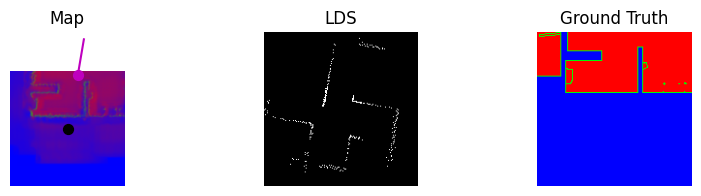

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [0. 0. 0. 0.]


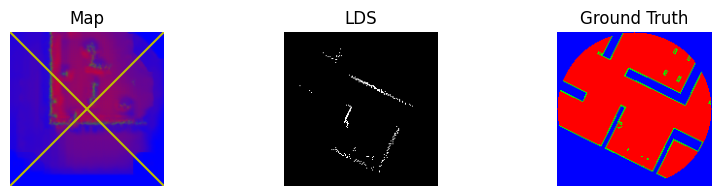

In [145]:
# Takes about 3 mins to run.
np.random.seed(0)
start = timer()
dataset = slam_data.generate_training_data(floorplan, num_samples=1000, model=model, model_weight=1.0)
duration = (timer() - start)
print(f"Dataset generated in {duration} sec")
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)

In [146]:
# save dataset
slam_data.save_dataset(dataset, 'experimental-slam-training-data2.npz')

Saving:
  input_maps:        (1000, 159, 159, 3)
  lds_maps:          (1000, 159, 159)
  ground_truth_maps: (1000, 159, 159, 3)
  adlos:             (1000, 4)
Dataset saved to experimental-slam-training-data2.npz


## Learnings
* Dataset generation:
  * The dataset has too many edge-cases compared to normal situation.
  * One way to improve this would be to weight the sample types. An alternative would be to finish up the loss functions and have them apply importance weighting.

* While the quick hack to have generate_training_data() use the predicted input maps gives a quick win. It's not realistic for training time, as data generation is very slow. In the longer term I'll be targeting a dataset of 10,000, with many floorplans. And re-running that every few epochs is just going to slow down training too much. So I'll need to build the method for augmenting the dataset post-generation.


## Next steps
Note: I've taken the output of this and used in `Experiment-SLAM-3.ipynb` and it's working! Yay. So that proves the basic idea. Now to move ahead by fully committing to it.

Next tasks:

* Final stage of accurate dataset generation: carefuly verify that generate_training_data() is generating realistic samples.
* It might make sense to represent "ignore output map" in training data by blanking it out for sample types 2 and 3.
* Add metadata to dataset.
* Build dataset augmentation routine to replace the input maps with predicted ones.

After that, will be in a position to go back to the training algorithm and:
* Improve loss functions to apply importance weighting based on dataset metadata.
* Use curriculum training with gradually augmented input maps using the model outputs.
